## Backtest Porfolio Strategies Part 2

In Chap 3 we have already defined a function to backtest a strategy. Here I want to take into consideration that shares are integer numbers. So you need a minimum initial capital to buy the number of shares of each asset in a portfolio to respect the weights assigned to the assets.

My **objective** in this notebook is to compare the backtesting results from the function defined in Chap 3 with the results coming from this approach that takes integer numbers of shares.

In [1]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
from Utils import prices, portfolio_prices

In [3]:
plt.style.use('ggplot')

#### 1. Collect asset historical prices and create a DataFrame

I take the same 4 ETFs taken in Chap 3 so that I can compare the two approaches.

In [4]:
tickers = ['CSSPX','PHAU','EM710','ITPS']

# taking single asset prices
data = []
for tick in tickers:
    data.append(prices(ticker=tick))

# structuring asset prices in a DataFrame
pf_prices = portfolio_prices(data)

pf_prices.head(3)

,CSSPX,PHAU,EM710,ITPS
Date,,,,
2010-05-19,72.849998,95.830002,122.160004,133.350006
2010-05-20,72.849998,95.070000,122.199997,132.089996
2010-05-21,72.849998,93.260002,122.349998,130.199997


### 2. Strategy to backtest.

I fix
* the `initial_capital` I want to invest
* the `initial_weights` per each ETF
* the `rebalance_frequency` in days to report the weight of each asset at their initial values.

In [5]:
# portfolio strategy assumptions
initial_capital = 100000
rebalance_frequency = 252
initial_weights = np.array([1/len(tickers)]*len(tickers))
#initial_weights = np.array([0.34, 0.22, 0.22, 0.22])
initial_weights

array([0.25, 0.25, 0.25, 0.25])

I can **simulate** on a daily basis the evolution of my porfolio, by tracking `shares` and `portfolio_values`.

In [6]:
# Initialize shares and portfolio value tracking
shares = pd.DataFrame(0, index=pf_prices.index, columns=pf_prices.columns, dtype=np.int64)
portfolio_values = pd.Series(name='portfolio', index=pf_prices.index, dtype=np.float64)

I need to use the floor division `//` to calculate the (integer) number of shares I can buy of each ETF given my `initial_capital` and the `initial_weights` per ETF of my strategy.
$$\text{nr of shares of ETF} = \frac{\text{initial capital} \cdot \text{initial weight of ETF}}{\text{price of ETF}}$$

In [7]:
# Buy initial shares
shares.iloc[0] = (initial_weights * initial_capital) // pf_prices.iloc[0]
portfolio_values.iloc[0] = (shares.iloc[0] * pf_prices.iloc[0]).sum()

*Note that I use the floor division `//` because I can only buy integer numbers of shares and not fractions of them.*

In [8]:
# track weights' evolution
weights = pd.DataFrame(index=pf_prices.index, columns=pf_prices.columns, dtype=np.float64)
weights.iloc[0] = (shares.iloc[0] * pf_prices.iloc[0]) / portfolio_values.iloc[0]

In [9]:
# Simulate over time
for t in range(1, len(pf_prices)):
    # Update portfolio value based on new prices
    portfolio_values.iloc[t] = (shares.iloc[t-1] * pf_prices.iloc[t]).sum()

    if rebalance_frequency > 0 and t % rebalance_frequency == 0:
        # Rebalance: Buy/Sell shares to restore original weights
        shares.iloc[t] = (initial_weights * portfolio_values.iloc[t]) // pf_prices.iloc[t]
        # Update portfolio value after rebalance
        portfolio_values.iloc[t] = (shares.iloc[t] * pf_prices.iloc[t]).sum()
    else:
        # No rebalance: Shares stay the same
        shares.iloc[t] = shares.iloc[t-1]

    # Compute weights
    weights.iloc[t] = (shares.iloc[t] * pf_prices.iloc[t]) / portfolio_values.iloc[t]

I can visualize the results of my backtest.

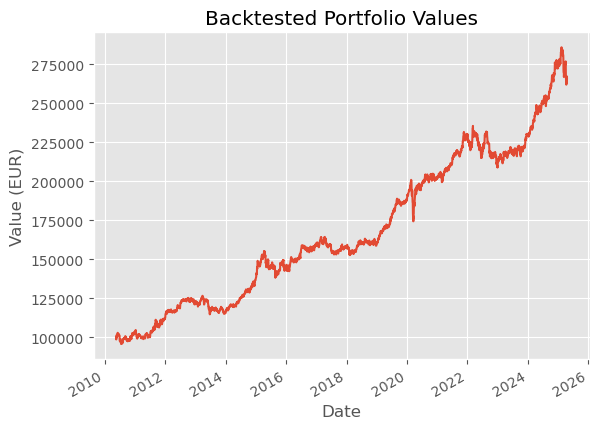

In [10]:
# Visualizing portfolio values overtime
portfolio_values.plot(title='Backtested Portfolio Values', ylabel='Value (EUR)')
plt.show()

In addition to the evolution over time of the porfolio values, I can visualize also:
- the evolution over time of the number of shares held per each ETF, 
- the evolution over time of the weights of each ETF in the portfolio values.

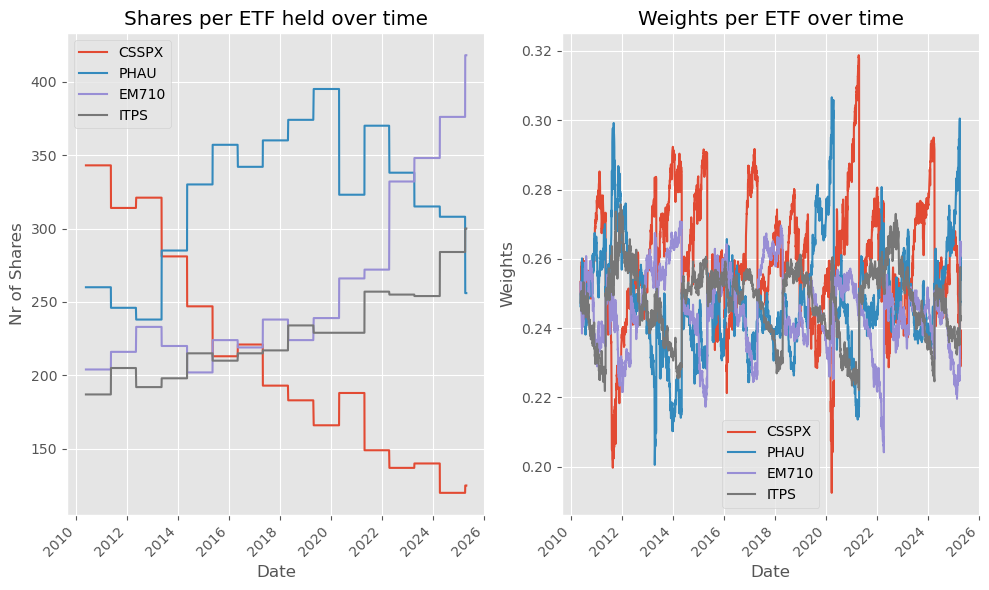

In [11]:
# Visualizing the evolution of nr of shares and weights of each ETF over time
# Create a figure and an array of axes: 1 rows, 2 columns
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10,6))
ax = ax.flatten()

shares.plot(ax=ax[0], title='Shares per ETF held over time', ylabel='Nr of Shares', rot=45)
weights.plot(ax=ax[1], title='Weights per ETF over time', ylabel='Weights', rot=45)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

#### 3. Writing a backtest function with integer numbers of shares.

Now I can write a function backtesting my strategy returning the `shares` over time of the each asset and `protfolio_values`.
Notice that:
1. in the function I have considered also the option of *buy-and-hold* strategy, not rebalancing the assets;
2. `weights` over time are not returned because they can be calculated multipling the `ticker_prices` Dataframe by the `shares` Dataframe and dividing by the `portfolio_values` over time (both `shares` and `portfolio_values` are returned by this fuction).

In [12]:
def backtest_sim(ticker_prices, initial_capital, initial_weights, rebalance_frequency=None):
    """
    Simulates a portfolio backtest with discrete shares and optional rebalancing.

    Parameters:
    - ticker_prices (pd.DataFrame): Daily prices of each asset (indexed by date)
    - initial_capital (float): Starting capital
    - initial_weights (np.array): Portfolio weights
    - rebalance_frequency (int or None): Rebalance every N steps. If None, no rebalancing.

    Returns:
    - shares (pd.DataFrame): Number of shares held per asset over time
    - portfolio_values (pd.Series): Portfolio value over time
    """
    shares = pd.DataFrame(0, index=ticker_prices.index, columns=ticker_prices.columns, dtype=np.int64)
    portfolio_values = pd.Series(index=ticker_prices.index, name='Portfolio', dtype=np.float64)

    # Buy initial shares
    prices_0 = ticker_prices.iloc[0]
    shares.iloc[0] = (initial_weights * initial_capital) // prices_0
    portfolio_values.iloc[0] = (shares.iloc[0] * prices_0).sum()

    # Define rebalancing dates (indices)
    rebalance_dates = set(np.arange(0, len(ticker_prices), rebalance_frequency)) if rebalance_frequency else set()

    for t in range(1, len(ticker_prices)):
        date = ticker_prices.index[t]
        prev_date = ticker_prices.index[t - 1]

        # Default: carry forward previous shares
        shares.loc[date] = shares.loc[prev_date]

        # Portfolio value before (or after) rebalance
        portfolio_values.at[date] = (shares.loc[date] * ticker_prices.loc[date]).sum()

        # Rebalance if needed
        if t in rebalance_dates:
            new_shares = (initial_weights * portfolio_values.at[date]) // ticker_prices.loc[date]
            shares.loc[date] = new_shares
            portfolio_values.at[date] = (new_shares * ticker_prices.loc[date]).sum()

    return shares, portfolio_values

In [13]:
# Example usage of the new function
shares_test, portfolio_values_test = backtest_sim(ticker_prices=pf_prices,
                                                       initial_weights=initial_weights,
                                                       initial_capital=initial_capital,
                                                       rebalance_frequency=252)

In [14]:
# showing how calculating weights over time from the results of the new function
weights_test = shares_test*pf_prices/portfolio_values_test.values.reshape(-1,1)
weights_test.head(3)

,CSSPX,PHAU,EM710,ITPS
Date,,,,
2010-05-19,0.250476,0.249756,0.249805,0.249963
2010-05-20,0.251547,0.248836,0.250956,0.248661
2010-05-21,0.253573,0.246064,0.253287,0.247076


I want to check that results returned by the `backtest_sim()` function are the same that I had before writing the function.

In [15]:
# checking that portfolio_values are the same
np.sum(portfolio_values == portfolio_values_test)

3793

In [16]:
# checking that number of shares held over time are the same per each ETF
np.sum(shares == shares_test, axis=0)

CSSPX    3793
PHAU     3793
EM710    3793
ITPS     3793
dtype: int64

In [17]:
# checking that weights over time are the same per each ETF
np.sum(weights == weights_test, axis=0)

CSSPX    3793
PHAU     3793
EM710    3793
ITPS     3793
dtype: int64

In [18]:
# checking that the lenghts of the outputs match the lenght of the historical prices
len(pf_prices)

3793

#### 4. So What?

I want to compare the results of this function tacking into account integer numbers of shares with the results of the function defined in Chap. 3.

To understand the difference between the results of the two functions, I will show what happens when I start from different `initial_capitals`.

In [19]:
initial_capitals = [10000, 50000, 100000]

In [20]:
from Utils import backtest_portfolio

In [21]:
# backetsting the same strategy with the function from Chap 3
results = backtest_portfolio(prices=pf_prices, weights=initial_weights,
                             rebalance=True, rebalance_freq=252)

In [22]:
# using the new functions with different initial capitals
new_func_results = []
for initial_capital in initial_capitals:
    shares, portfolio_values = backtest_sim(ticker_prices=pf_prices,
                                                       initial_weights=initial_weights,
                                                       initial_capital=initial_capital,
                                                       rebalance_frequency=252)
    new_func_results.append(portfolio_values)

To compare the results of the two approaches, I can eithr multiply `results` by `initial_capital` or normalize the pd.Series `portfolio_values` to the `initial_capital`.

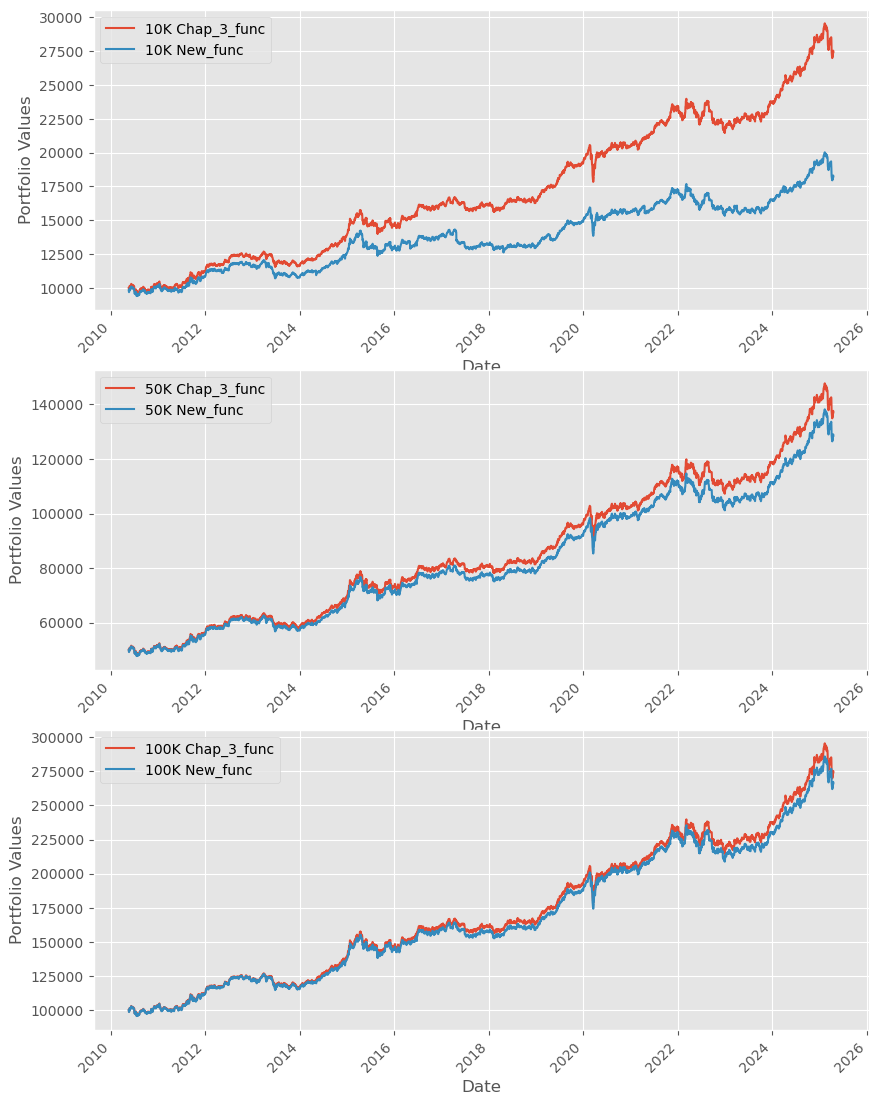

In [23]:
init_cap_labels = ['10K', '50K', '100K']

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # 3 roww, 1 column

for i, pf_vals in enumerate(new_func_results):
    (results.Portfolio*initial_capitals[i]).plot(ax=axes[i], 
                                                 ylabel='Portfolio Values',
                                                 label=init_cap_labels[i]+' Chap_3_func',rot=45)
    pf_vals.plot(ax=axes[i], 
                 ylabel='Portfolio Values',
                 label=init_cap_labels[i]+' New_func',rot=45)
    axes[i].legend()
    #_= plt.plot(pf_vals, label='new_func-init_cap: '+init_cap_labels[i])
#_= plt.legend()
plt.show()

We can see that the Porfolio Values backtested with the new function `backtest_sim()` become closer the the values returned by the function defined in Chap 3 as long as the `initial_capital` increases. This is logical, because with smaller `initial_capitals` we cannot allocate all the money we have to buy integer number of shares according to the `initial_weights` of the strategy.

So this new `backtest_sim()` function gives a more realistic view when bactesting a strategy. I will include also this function in the `Utils.py` toolkit for Porftolio Analyses.

#### 5. Another possible approach for backtesting

Instead of simulating daily evolutions, I want to find a **more immediate** way to backtest my strategy using vectorized operations allowed by `pandas` and `numpy`.

In [24]:
# Identify rebalance index positions in the historical series DataFrame
idx_rebalance = [i for i in range(len(pf_prices)) if i % rebalance_frequency == 0]

I want to see that my `historical_price` dataframe is subsetced at days of rebalance:

In [25]:
pf_prices.iloc[idx_rebalance].head() # taking prices at rebalance dates

,CSSPX,PHAU,EM710,ITPS
Date,,,,
2010-05-19,72.849998,95.830002,122.160004,133.350006
2011-05-12,80.820000,103.339996,117.580002,124.010002
2012-05-07,91.080002,123.000000,125.629997,152.110001
2013-05-07,110.129997,108.419998,140.539993,155.910004
2014-05-07,120.970001,90.720001,148.070007,139.009995


In [26]:
# Initialize shares value tracking
shares = pd.DataFrame(0, index=pf_prices.iloc[idx_rebalance].index,
                      columns=pf_prices.columns, dtype=np.int64)
shares.iloc[0] = ((initial_weights * initial_capital) // pf_prices.iloc[idx_rebalance[0]]).astype('int')

In [27]:
for t in range(1,len(idx_rebalance)):
  portfolio_val = (shares.iloc[t-1] * pf_prices.iloc[idx_rebalance[t]]).sum()
  shares.iloc[t] = ((initial_weights * portfolio_val) // pf_prices.iloc[idx_rebalance[t]]).astype('int')

In [28]:
# create the daily shares
shares = shares.reindex(pf_prices.index, method='ffill')

I use the variable `portfolio_values_1` because I want to check that the results obtained with this more immediate approach are identical to the simulation approach.

In [29]:
# checking that all dates have been carried over in the backtesting
portfolio_values_1 = shares*pf_prices
len(portfolio_values_1) == len(pf_prices)

True

Notice that here I got a DataFrame with daily values of each ETF in portfolio. Then to calculate the daily portfolio value over time I can use the `.sum(axis=1)` method calculating the sum of each row in the DataFrame.

In [30]:
portfolio_values_1.head()

,CSSPX,PHAU,EM710,ITPS
Date,,,,
2010-05-19,24987.549477,24915.800476,24920.640747,24936.451141
2010-05-20,24987.549477,24718.199921,24928.799377,24700.829315
2010-05-21,24987.549477,24247.600555,24959.399689,24347.399429
2010-05-24,24987.549477,24736.399841,24994.079315,24755.060913
2010-05-25,24987.549477,25115.999603,25028.760498,25123.451141


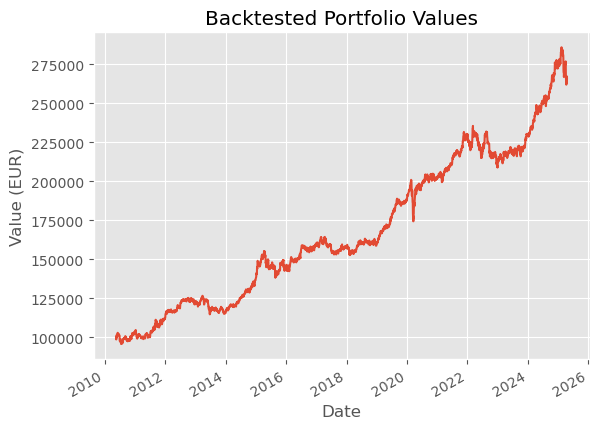

In [31]:
# Visualizing portfolio values overtime
portfolio_values_1.sum(axis=1).plot(title='Backtested Portfolio Values', ylabel='Value (EUR)')
plt.show()

In [32]:
# comparing results between simulation and more immediate approach
np.sum(portfolio_values == portfolio_values_1.sum(axis=1))

3793

In [33]:
# calculating weights over time of each ETF
weights_1 = portfolio_values_1/portfolio_values_1.sum(axis=1).values.reshape(-1,1)

In [34]:
# checking that the results are the same of the simulation approach
np.sum(weights == weights_1, axis=0)

CSSPX    3793
PHAU     3793
EM710    3793
ITPS     3793
dtype: int64

As before, I can then write a function backtesting my strategy returning the `shares` over time of the each asset and `protfolio_values` of each asset.
Notice that also in this case:
1. the function considers the option of *buy-and-hold* strategy, not rebalancing the assets;
2. `weights` over time are not returned because they can be calculated as shown above buy dividing the returned `potfolio_values` DataFrame by `portfolio_values.sum(axis=1)` which is the total portfolio daily values.

In [35]:
def backtest_vect(ticker_prices, initial_capital, initial_weights, rebalance_frequency=None):
    """
    Vectorized backtesting simulation of a portfolio with optional rebalancing.

    This function simulates portfolio performance using vectorized operations for efficiency.

    Args:
        ticker_prices (pd.DataFrame): DataFrame containing ticker prices,
        with dates as index and tickers as columns.
        initial_capital (float): The initial capital for the portfolio.
        initial_weights (np.array): array containing initial weights for each ticker.
        rebalance_frequency (int, optional): Frequency of rebalancing (e.g., 30 for monthly rebalancing).
        If None, no rebalancing occurs.

    Returns:
        tuple: A tuple containing two pandas DataFrames:
            - shares (pd.DataFrame): DataFrame showing the number of shares held of each ticker at each time step.
            - portfolio_values (pd.DataFrame): DataFrame showing the value of each ticker at each time step.
    """

    if rebalance_frequency == None:
        shares = pd.DataFrame(index=ticker_prices.index, columns=ticker_prices.columns, dtype=np.int64)
        shares.iloc[0] = ((initial_weights*initial_capital)//ticker_prices.iloc[0]).astype('int')
        shares = shares.ffill()
        portfolio_values = (ticker_prices* shares).sum(axis=1)
        return shares, portfolio_values

    # Identify rebalance index positions in the historical series DataFrame
    idx_rebalance = [i for i in range(len(ticker_prices)) if i % rebalance_frequency == 0]
    # Initialize shares value tracking
    shares = pd.DataFrame(0, index=ticker_prices.iloc[idx_rebalance].index,
                        columns=ticker_prices.columns, dtype=np.int64)
    shares.iloc[0] = ((initial_weights * initial_capital) // ticker_prices.iloc[idx_rebalance[0]]).astype('int')

    for t in range(1,len(idx_rebalance)):
        portfolio_val = (shares.iloc[t-1] * ticker_prices.iloc[idx_rebalance[t]]).sum()
        shares.iloc[t] = ((initial_weights * portfolio_val) // ticker_prices.iloc[idx_rebalance[t]]).astype('int')

    # create the daily shares
    shares = shares.reindex(ticker_prices.index, method='ffill')
    portfolio_values = shares*ticker_prices

    return shares, portfolio_values


In [36]:
# Example usage of the function
shares_test_2, portfolio_values_test_2 = backtest_vect(ticker_prices=pf_prices,
                                                                initial_capital=initial_capital,
                                                                initial_weights=initial_weights,
                                                                rebalance_frequency=rebalance_frequency)

When running this function you may notice that the execution time is shorter than the `backtest_sim()` especially when the backtest is done on longer historical series.

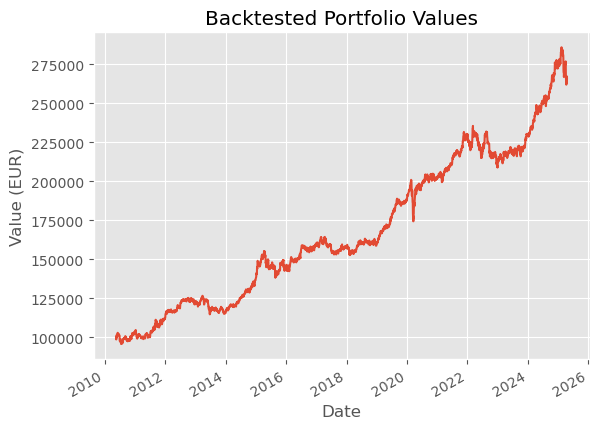

In [37]:
# Visualizing portfolio values overtime
portfolio_values_test_2.sum(axis=1).plot(title='Backtested Portfolio Values', ylabel='Value (EUR)')
plt.show()

In [38]:
# comparing function results to the devlopment of the more immediate approach
np.sum(portfolio_values_1 == portfolio_values_test_2, axis=0)

CSSPX    3793
PHAU     3793
EM710    3793
ITPS     3793
dtype: int64

In [39]:
# comparing function results to the devlopment of the more immediate approach
np.sum(portfolio_values_1.sum(axis=1) == portfolio_values_test_2.sum(axis=1))

3793

In [40]:
# comparing the results with the two functions sim and vect
np.sum(portfolio_values_test == portfolio_values_test_2.sum(axis=1))

3793

#### Summary

In this chapter we have seen the importance of taking into consideration that shares are integer numbers, when bactesting a strategy. In fact, the portafolio values over time differ depending on the `initial_capital` available. So the `initial_capital` available is somehow an important assumption in the strategy being tested.

Then we have defined two functions `backtest_sim` and `backtest_vect` to backtest strategies taking integer numbers of shares of each asset in portfolio. Both give the same results. I'll include in the `Utils.py` toolkit the function `backtest_sim`, returning the DataFrame of shares held over time per each asset and the pd.Series of the portfolio values over time.